# Module imports, data input and cleaning

In [32]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import matplotlib.cm as cm
import scipy.io

%matplotlib inline

In [33]:
df = pd.read_excel("/Users/jinxiaoyang/Downloads/Online Retail.xlsx")
print(df.shape)
df.head(3)

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


<AxesSubplot:xlabel='Percent missing', ylabel='Feature'>

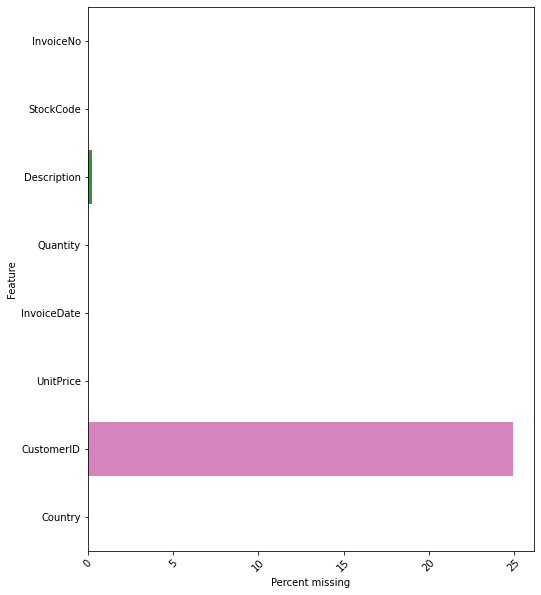

In [35]:
'''Calculate percentage null values for each column or feature'''

null_vals = df.isnull().sum()/len(df)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,10))
plt.xticks(rotation=45)
sns.barplot(x = "Percent missing",y ="Feature",data = null_vals,orient = "h")

In [36]:
#drop rows with null values
df1 = df.dropna(subset = ["CustomerID", "Description"])
print(df.shape, df1.shape)

(541909, 8) (406829, 8)


In [37]:
#check duplicate rows
df2 = df1.drop_duplicates()
print(df2.shape)

(401604, 8)


In [38]:
#we only care about who shoped when, what, how much money spent
df3 = df2[['CustomerID', 'InvoiceDate', 'InvoiceNo', 'Quantity', 'UnitPrice']]
print(df3.shape)
df3.head(2)

(401604, 5)


,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55
1,17850.0,2010-12-01 08:26:00,536365,6,3.39


Feature Engineering

In [39]:
#create a total price column
df3['TotalPrice'] = df3['Quantity'] * df3['UnitPrice']
print(df3.shape)
df3.head(2)

(401604, 6)


/var/folders/cn/ltkk5y791k55q6_3b9f218s40000gn/T/ipykernel_8618/1074547488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['TotalPrice'] = df3['Quantity'] * df3['UnitPrice']


,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


In [40]:
#check the earliest and latest dates in the data
print('Min:{}; Max:{}'.format(df3["InvoiceDate"].min(), df3["InvoiceDate"].max()))

Min:2010-12-01 08:26:00; Max:2011-12-09 12:50:00


In [41]:
#create a reference point for this analysis
current_date = dt.datetime(2011,12,10)
current_date

datetime.datetime(2011, 12, 10, 0, 0)

In [42]:
#Calculate the aggregates" recency, frequency and, monetary. 
#Recency tells you how many days since last transaction for each customer
#frequency tells you how frequently does a customer shop
#monetary tells you the total shopping spending for each customer

df4 = df3.groupby(['CustomerID']).agg({ 'InvoiceDate': lambda x: (current_date - x.max()).days, 'InvoiceNo': 'count',
'TotalPrice': 'sum'})
df4.rename(columns = {'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency','TotalPrice': 'Monetary'}, inplace=True)
print(df4.shape)
df4.head(3)

(4372, 3)


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24


In [43]:
#Remove rows with any zero values. This is to facilitate downstream pre-processing and avoid NaNs

df5 = df4[(df4 > 0).all(1)]
print(df5.shape)

(4284, 3)


# Data Pre-processing

The K-means clustering algorithm has a few key assumptions about the data: (1) data is not skewed, 
(2) features have the same mean and, (3) features have the same variance

In [44]:
df5.describe()

,Recency,Frequency,Monetary
count,4284.000000,4284.000000,4.284000e+03
mean,90.673436,90.187675,1.802891e+03
std,99.212825,217.749044,7.226246e+03
min,1.000000,1.000000,1.776357e-15
25%,17.000000,18.000000,2.988725e+02
50%,50.000000,42.000000,6.467200e+02
75%,140.000000,99.000000,1.596963e+03
max,373.000000,7812.000000,2.794890e+05


we need to make them have the same mean and std. Looks like the means and standard deviations are so different. So, we need to transform the data to meet the requirements

/Users/jinxiaoyang/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Recency', ylabel='Density'>

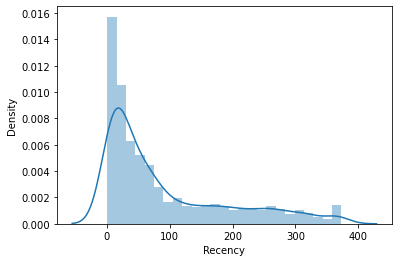

In [45]:
sns.distplot(df5['Recency'])

/Users/jinxiaoyang/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Frequency', ylabel='Density'>

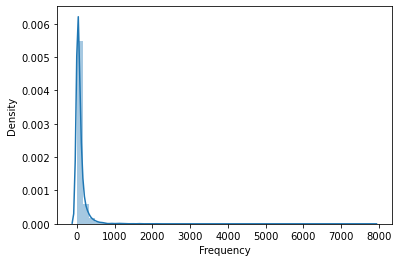

In [46]:
sns.distplot(df5['Frequency'])

/Users/jinxiaoyang/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Monetary', ylabel='Density'>

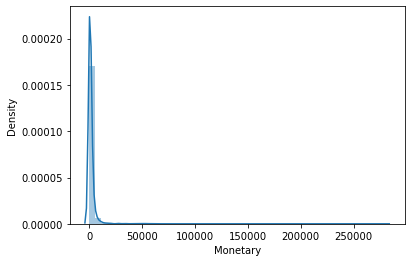

In [47]:
sns.distplot(df5['Monetary'])

We log transform the data to remove the skew. Add a constant to offset any negative values.

In [48]:
df6 = (np.log(df5 + 1))
print(df6.shape)
df6.head(3)

(4284, 3)


,Recency,Frequency,Monetary
CustomerID,,,
12347.0,1.098612,5.209486,8.368925
12348.0,4.330733,3.465736,7.494564
12349.0,2.944439,4.304065,7.472245


/Users/jinxiaoyang/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Recency', ylabel='Density'>

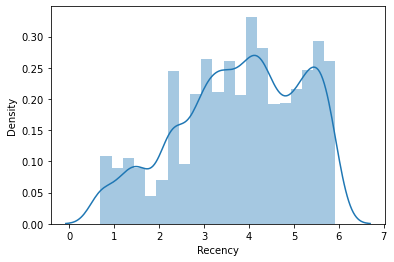

In [49]:
sns.distplot(df6['Recency'])

/Users/jinxiaoyang/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Frequency', ylabel='Density'>

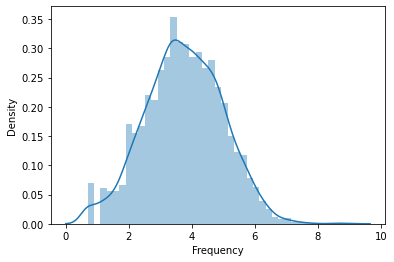

In [50]:
sns.distplot(df6['Frequency'])

/Users/jinxiaoyang/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Monetary', ylabel='Density'>

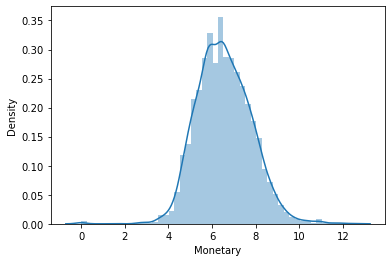

In [51]:
sns.distplot(df6['Monetary'])

It has made the data look more normal

In [52]:
#Do scaling to make sure all dimensions have equal mean and variance

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
scaler.fit(df6)
df7 = pd.DataFrame(scaler.transform(df6))
df7.columns = df6.columns
df7.describe()

,Recency,Frequency,Monetary
count,4.284000e+03,4.284000e+03,4.284000e+03
mean,2.107462e-16,-2.522622e-16,-9.511014e-17
std,1.000117e+00,1.000117e+00,1.000117e+00
min,-2.257018e+00,-2.483190e+00,-5.244693e+00
25%,-6.530189e-01,-6.529482e-01,-6.740816e-01
50%,1.072545e-01,1.105753e-02,-5.693016e-02
75%,8.496283e-01,6.971834e-01,6.667453e-01
max,1.561752e+00,4.240429e+00,4.805312e+00


In [53]:
print(df7)

       Recency  Frequency  Monetary
0    -1.961024   1.188477  1.462077
1     0.398462  -0.229147  0.761373
2    -0.613549   0.452393  0.743487
3     1.427092  -0.696903 -0.584353
4    -0.127012   0.663996  0.640466
...        ...        ...       ...
4279  1.345205  -1.097274 -1.076019
4280  1.031939  -1.356169 -1.714955
4281 -1.245007  -0.901216 -1.093868
4282 -1.751013   2.304316  0.865023
4283 -0.017304   0.418748  0.779021

[4284 rows x 3 columns]


# K-means clustering

In [54]:
from numpy import *
import time
import matplotlib.pyplot as plt

# calculate Euclidean distance
def euclDistance(vector1, vector2):
    return sqrt(sum(power(vector2 - vector1, 2)))
 
# init centroids with random samples
def initCentroids(dataSet, k):
    numSamples, dim = dataSet.shape
    centroids = zeros((k, dim))
    for i in range(k):
        index = int(random.uniform(0, numSamples))
        centroids[i, :] = dataSet[index, :]
    return centroids
 
# k-means cluster
def kmeans(dataSet, k):
    numSamples = dataSet.shape[0]
    # first column stores which cluster this sample belongs to,
    # second column stores the error between this sample and its centroid
    clusterAssment = mat(zeros((numSamples, 2)))
    clusterChanged = True
 
    ## step 1: init centroids
    centroids = initCentroids(dataSet, k)
 
    while clusterChanged:
        clusterChanged = False
        ## for each sample
        for i in range(numSamples):
            minDist  = 100000.0
            minIndex = 0
            ## for each centroid
            ## step 2: find the centroid who is closest
            for j in range(k):
                distance = euclDistance(centroids[j, :], dataSet[i, :])
                if distance < minDist:
                    minDist  = distance
                    minIndex = j

            ## step 3: update its cluster
            if clusterAssment[i, 0] != minIndex:
                clusterChanged = True
                clusterAssment[i, :] = minIndex, minDist**2
 
        ## step 4: update centroids
        for j in range(k):
            pointsInCluster = dataSet[nonzero(clusterAssment[:, 0].A == j)[0]]
            centroids[j, :] = mean(pointsInCluster, axis = 0)
 
    print ('Congratulations, cluster complete!')
    return centroids, clusterAssment
 
# show your cluster only available with 2-D data
def showCluster(dataSet, k, centroids, clusterAssment):
    numSamples, dim = dataSet.shape
    if dim != 2:
        print ("Sorry! I can not draw because the dimension of your data is not 2!")
        return 1
 
    mark = ['or', 'ob', 'og', 'ok', '^r', '+r', 'sr', 'dr', '<r', 'pr']
    if k > len(mark):
        print ("k is too large!")
        return 1
 
    # draw all samples
    # https://blog.csdn.net/sinat_36219858/article/details/79800460
    #colors = ['r', 'g', 'b', 'y', 'c', 'm']
    for i in range(numSamples):
        markIndex = int(clusterAssment[i, 0])
        plt.plot(dataSet[i, 0], dataSet[i, 1], mark[markIndex])
        #plt.scatter(dataSet[i, 0], dataSet[i, 1], c=colors, s=4)
 
    mark = ['Dr', 'Db', 'Dg', 'Dk', '^b', '+b', 'sb', 'db', '<b', 'pb']
    # draw the centroids
    for i in range(k):
        plt.plot(centroids[i, 0], centroids[i, 1], mark[i], markersize = 5)
        #plt.scatter(centroids[i, 0], centroids[i, 1], c='black', s=4)
 
    plt.show()

# Elbow method

In [56]:
from sklearn.cluster import KMeans

In [57]:
# Fit KMeans and calculate SSE for each *k*
ss_error = {}
for k in range(1, 20):
    k_means = KMeans(n_clusters=k, random_state=1)
    k_means.fit(df7)
    ss_error[k] = k_means.inertia_

<AxesSubplot:title={'center':'Elbow plot'}, xlabel='Value of k', ylabel='Sum of squared error'>

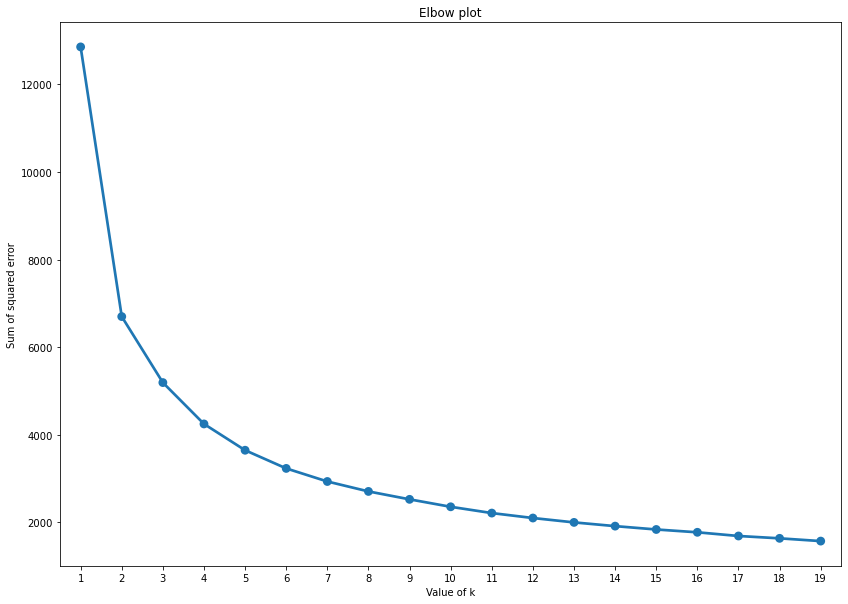

In [58]:
# Make elbow plot
plt.figure(figsize = (14,10))
plt.title('Elbow plot')
plt.xlabel('Value of k')
plt.ylabel('Sum of squared error')
sns.pointplot(x=list(ss_error.keys()), y=list(ss_error.values()))

# Test

In [60]:
df8 = pd.DataFrame(df7, columns = ['Frequency', 'Monetary'])
#df8 = df7.loc[:, ['Frequency', 'Monetary']]
#pd.DataFrame(df7, columns = ['Frequency', 'Monetary'])
#df8 = df7[:,[1,2]]
#df8 = df7[:,1:3]
print(df8)

      Frequency  Monetary
0      1.188477  1.462077
1     -0.229147  0.761373
2      0.452393  0.743487
3     -0.696903 -0.584353
4      0.663996  0.640466
...         ...       ...
4279  -1.097274 -1.076019
4280  -1.356169 -1.714955
4281  -0.901216 -1.093868
4282   2.304316  0.865023
4283   0.418748  0.779021

[4284 rows x 2 columns]


In [61]:
## step 1: load data
print("step 1: load data...")
# dataSet = []
# fileIn = open('E:/Python/Machine Learning in Action/testSet.txt')
# for line in fileIn.readlines():
#     lineArr = line.strip().split('\t')
#     dataSet.append([float(lineArr[0]), float(lineArr[1])])
 
## step 2: clustering...
print("step 2: clustering...")
df8 = mat(df8)

step 1: load data...
step 2: clustering...


Congratulations, cluster complete!
step 3: show the result...


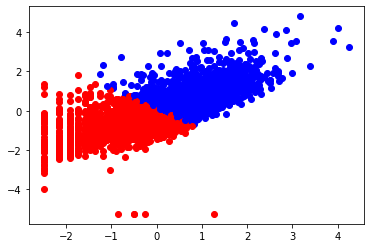

In [62]:
k = 2
centroids, clusterAssment = kmeans(df8, k)
 
## step 3: show the result
print("step 3: show the result...")
showCluster(df8, k, centroids, clusterAssment)

Congratulations, cluster complete!
step 3: show the result...


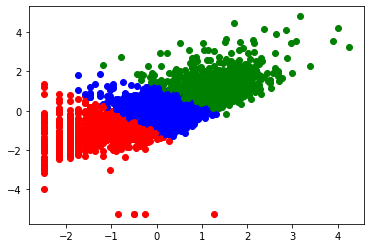

In [63]:
k = 3
centroids, clusterAssment = kmeans(df8, k)
 
## step 3: show the result
print("step 3: show the result...")
showCluster(df8, k, centroids, clusterAssment)

Congratulations, cluster complete!
step 3: show the result...


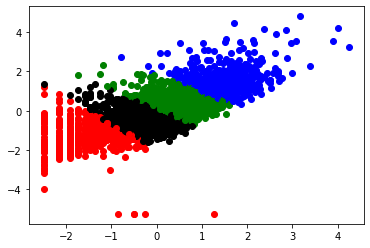

In [64]:
k = 4
centroids, clusterAssment = kmeans(df8, k)
 
## step 3: show the result
print("step 3: show the result...")
showCluster(df8, k, centroids, clusterAssment)

Congratulations, cluster complete!
step 3: show the result...


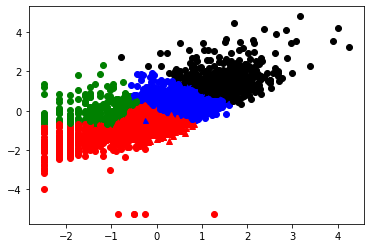

In [65]:
k = 5
centroids, clusterAssment = kmeans(df8, k)
 
## step 3: show the result
print("step 3: show the result...")
showCluster(df8, k, centroids, clusterAssment)

Congratulations, cluster complete!
step 3: show the result...


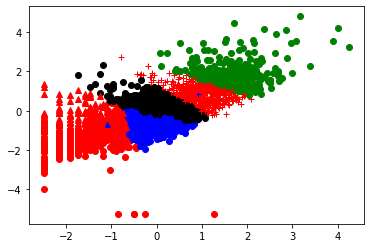

In [66]:
k = 6
centroids, clusterAssment = kmeans(df8, k)
 
## step 3: show the result
print("step 3: show the result...")
showCluster(df8, k, centroids, clusterAssment)

Congratulations, cluster complete!
step 3: show the result...


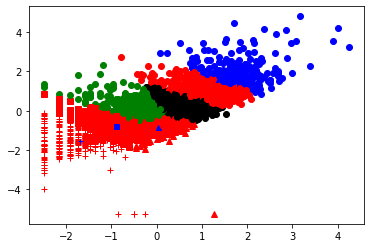

In [67]:
k = 7
centroids, clusterAssment = kmeans(df8, k)
 
## step 3: show the result
print("step 3: show the result...")
showCluster(df8, k, centroids, clusterAssment)

Congratulations, cluster complete!
step 3: show the result...


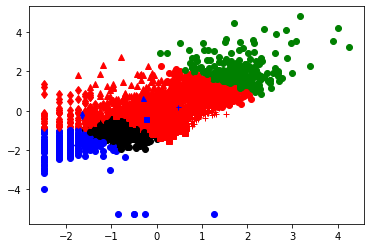

In [68]:
k = 8
centroids, clusterAssment = kmeans(df8, k)
 
## step 3: show the result
print("step 3: show the result...")
showCluster(df8, k, centroids, clusterAssment)

Congratulations, cluster complete!
step 3: show the result...


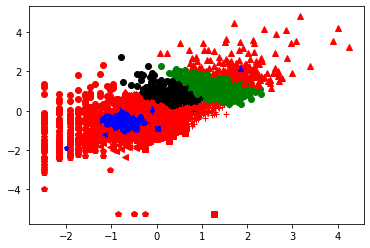

In [69]:
k = 10
centroids, clusterAssment = kmeans(df8, k)
 
## step 3: show the result
print("step 3: show the result...")
showCluster(df8, k, centroids, clusterAssment)

In [70]:
k = 12
centroids, clusterAssment = kmeans(df8, k)
 
## step 3: show the result
print("step 3: show the result...")
showCluster(df8, k, centroids, clusterAssment)

Congratulations, cluster complete!
step 3: show the result...
k is too large!


1